Game plan:

1. Load AutoGluon model
2. Wrap the data un-processor around it, to create a policy that can interact with MuJoCo Gym env.
3. Figure out what the logging data for RvS means. Download from WandB and decode them!
3. Replicate the violin plots.
4. Compute $\max_{\tilde r} E_{\pi( | , \tilde r)}[\sum_t r_t]$

In [1]:
%load_ext autoreload 
%autoreload 2 

import pickle
import os

from tqdm import trange
import pandas as pd
import seaborn as sns
import numpy as np
import autogluon as ag
import matplotlib.pyplot as plt
import mujoco_py
import gym

## Load AutoGluon

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

/home/deadscholar/miniconda3/envs/gluon/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Wrap a policy around it

In [3]:
class FastMultiPredictor():
    def __init__(self, predictor):
        self.labels = predictor.labels
        self.pred_list = []
        for label in self.labels:
            self.pred_list.append(predictor.get_predictor(label))

    def data_preprocessor(self, x):
        return np.arctanh(0.995 * np.clip(x, -1.0, +1.0))

    def data_un_preprocessor(self, x):
        return np.clip(np.tanh(x)/0.995, -1.0, +1.0)
    
    def obs_rtg_to_df(self, obs, rtg):
        if len(obs.shape) == 1:
            ob_dim = obs.shape[-1]
            df = pd.DataFrame()
            for i in range(ob_dim):
                df[f"ob{i}"] = [obs[i]]
            df["rtg"] = [rtg]
            return df
        else:
            ob_dim = obs.shape[-1]
            df = pd.DataFrame()
            for i in range(ob_dim):
                df[f"ob{i}"] = obs[:,i]
            df["rtg"] = rtg
            return df

    def persist_models(self):
        for i in self.pred_list:
            i.persist_models()
            
    def unpersist_models(self):
        for i in self.pred_list:
            i.unpersist_models()

    def predict(self, observation, rtg):
        arctanh_action = self.obs_rtg_to_df(observation, rtg)
        for i, pred in enumerate(self.pred_list):
            next_action_dim = pred.predict(arctanh_action)
            arctanh_action[self.labels[i]] = next_action_dim
        
        action = self.data_un_preprocessor(arctanh_action)
        return action[self.labels]
    
    @classmethod
    def load(cls, path):
        return FastMultiPredictor(MultilabelPredictor.load(path))

## Let's start the experiment, properly

In [4]:
def trainer(autogluon_policy, env_name, n_envs, n_iters, rtg_list):
    envs = gym.vector.make(env_name, num_envs=n_envs)
    ob_dim = envs.observation_space.shape[-1]
    ac_dim = envs.action_space[0].shape[-1]

    observation_record = np.zeros((n_iters, n_envs, ob_dim))
    action_record = np.zeros((n_iters, n_envs, ac_dim))
    reward_record = np.zeros((n_iters, n_envs))
    termination_record = np.zeros((n_iters, n_envs))

    for t in trange(n_iters):
        if t == 0:
            observation = envs.reset()
        observation_record[t,:,:] = observation
        action = autogluon_policy.predict(observation, rtg_list).to_numpy()
        observation, reward, terminated, info = envs.step(action)
        action_record[t,:,:] = action
        reward_record[t,:] = reward
        termination_record[t,:] = terminated
    envs.close()

    info = {"ob_dim": ob_dim, 
            "ac_dim": ac_dim, 
            "env_name": env_name, 
            "n_envs" : n_envs, 
            "n_iters" : n_iters,
            "rtg_list" : rtg_list}

    return observation_record, action_record, reward_record, termination_record, info

In [5]:
def make_rtg(low, high, unique_values, repeats):
    delta = (high - low) / (unique_values - 1)
    return np.repeat(np.array([low + delta * i for i in range(unique_values)]), repeats)

make_rtg(0.3, 1.2, 19, 3)

array([0.3 , 0.3 , 0.3 , 0.35, 0.35, 0.35, 0.4 , 0.4 , 0.4 , 0.45, 0.45,
       0.45, 0.5 , 0.5 , 0.5 , 0.55, 0.55, 0.55, 0.6 , 0.6 , 0.6 , 0.65,
       0.65, 0.65, 0.7 , 0.7 , 0.7 , 0.75, 0.75, 0.75, 0.8 , 0.8 , 0.8 ,
       0.85, 0.85, 0.85, 0.9 , 0.9 , 0.9 , 0.95, 0.95, 0.95, 1.  , 1.  ,
       1.  , 1.05, 1.05, 1.05, 1.1 , 1.1 , 1.1 , 1.15, 1.15, 1.15, 1.2 ,
       1.2 , 1.2 ])

In [6]:
%pdb on
pickle_folder = "pkl_files"
if not os.path.exists(pickle_folder):
      os.makedirs(pickle_folder)

env_list = ["Hopper", "Walker2d", "HalfCheetah"]
collection_policy_list = ['random', 'medium-replay', 'medium', 'medium-expert']

n_iters = 1999
unique_values = 10
repeats = 50
n_envs = unique_values * repeats
rtg_list_dict =     {
     "hopper-random" : make_rtg(0.3, 1.2, unique_values, repeats),
     "hopper-medium-replay" : make_rtg(0.3, 1.2, unique_values, repeats),
     "hopper-medium" : make_rtg(0.3, 1.2, unique_values, repeats),
     "hopper-medium-expert" : make_rtg(0.3, 1.2, unique_values, repeats),
     
     "walker2d-random" : make_rtg(-1.0, 1.0, unique_values, repeats),
     "walker2d-medium-replay" : make_rtg(0.0, 6.0, unique_values, repeats),
     "walker2d-medium" : make_rtg(0.0, 6.0, unique_values, repeats),
     "walker2d-medium-expert" : make_rtg(0.0, 6.0, unique_values, repeats),
     
     "halfcheetah-random" : make_rtg(-1.0, 1.0, unique_values, repeats),
     "halfcheetah-medium-replay" : make_rtg(0.0, 8.0, unique_values, repeats),
     "halfcheetah-medium" : make_rtg(0.0, 8.0, unique_values, repeats),
     "halfcheetah-medium-expert" : make_rtg(4.0, 14.0, unique_values, repeats),
    }

for env_name in env_list:
    for collection_policy_name in collection_policy_list:
        exp_name = f'{env_name.lower()}-{collection_policy_name}'
        pickle_file_path = f'{pickle_folder}/{exp_name}.pkl'
        if os.path.exists(pickle_file_path):
            print(f"{pickle_file_path} already exists, skipping...")
        else:
            fast_predictor = FastMultiPredictor.load(f'agModels/{exp_name}-v2')

            fast_predictor.persist_models()
            print(exp_name)
            print(fast_predictor.labels)
            rtg_list = rtg_list_dict[f"{exp_name}"]
            output = trainer(fast_predictor, f"{env_name}-v2", n_envs, n_iters, rtg_list)

            fast_predictor.unpersist_models()

            with open(f'{pickle_folder}/{exp_name}.pkl', 'wb') as fh:
                pickle.dump(output, fh)

Automatic pdb calling has been turned ON
pkl_files/hopper-random.pkl already exists, skipping...
pkl_files/hopper-medium-replay.pkl already exists, skipping...
pkl_files/hopper-medium.pkl already exists, skipping...
pkl_files/hopper-medium-expert.pkl already exists, skipping...
pkl_files/walker2d-random.pkl already exists, skipping...
pkl_files/walker2d-medium-replay.pkl already exists, skipping...
walker2d-medium
['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']


100%|███████████████████████████████████████████████████████████████████████████████| 1999/1999 [51:57<00:00,  1.56s/it]


walker2d-medium-expert
['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']


100%|███████████████████████████████████████████████████████████████████████████████| 1999/1999 [31:57<00:00,  1.04it/s]


halfcheetah-random
['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']


100%|███████████████████████████████████████████████████████████████████████████████| 1999/1999 [28:36<00:00,  1.16it/s]


halfcheetah-medium-replay
['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']


100%|█████████████████████████████████████████████████████████████████████████████| 1999/1999 [1:02:23<00:00,  1.87s/it]


halfcheetah-medium
['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']


100%|███████████████████████████████████████████████████████████████████████████████| 1999/1999 [59:51<00:00,  1.80s/it]


halfcheetah-medium-expert
['ac0', 'ac1', 'ac2', 'ac3', 'ac4', 'ac5']


100%|███████████████████████████████████████████████████████████████████████████████| 1999/1999 [33:46<00:00,  1.01s/it]


## Figure out what the logging data for RvS means

![](./example_violin_plot.png)

In [47]:
example_csv = pd.read_csv('example_csv.csv')
example_csv[1999:2020]

,Return,Policy,Reward Target,Checkpoint
1999,10636.071365,RCBC,1.2,Last
2000,4669.482422,Demonstrator,NaN,NaN
2001,4880.028320,Demonstrator,NaN,NaN
2002,4932.505371,Demonstrator,NaN,NaN
2003,4809.520020,Demonstrator,NaN,NaN
2004,4899.353516,Demonstrator,NaN,NaN
2005,4847.325195,Demonstrator,NaN,NaN
2006,4961.241211,Demonstrator,NaN,NaN
2007,4789.391113,Demonstrator,NaN,NaN
2008,4774.562012,Demonstrator,NaN,NaN


## Replicate the logging data and plots

<AxesSubplot: xlabel='deck', ylabel='age'>

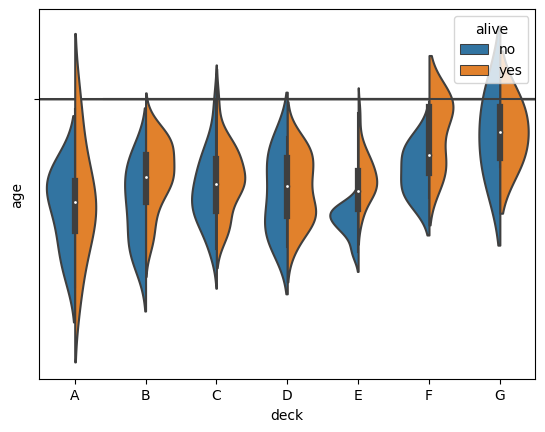

In [4]:
import seaborn as sns
df = sns.load_dataset("titanic")
sns.violinplot(data=df, x="deck", y="age", hue="alive", split=True)

## Plot the things

In [17]:
# Load real experiment data
import pickle

exp_name_list = []
observation_record_dict = {}
action_record_dict = {}
reward_record_dict = {}
termination_record_dict = {}
rtg_list_dict = {}

for env_name in env_list:
    for collection_policy_name in collection_policy_list:
        exp_name = f'{env_name.lower()}-{collection_policy_name}'
        exp_name_list.append(exp_name)
        pickle_file_path = f'pkl_files/{exp_name}.pkl'
        with open(pickle_file_path, 'rb') as fh:
            observation_record, action_record, reward_record, termination_record, info = pickle.load(fh)
        observation_record_dict[exp_name] = observation_record
        action_record_dict[exp_name] = action_record
        reward_record_dict[exp_name] = reward_record
        termination_record_dict[exp_name] = termination_record
        rtg_list_dict[exp_name] = info['rtg_list']

print(exp_name_list)

['hopper-random', 'hopper-medium-replay', 'hopper-medium', 'hopper-medium-expert', 'walker2d-random', 'walker2d-medium-replay', 'walker2d-medium', 'walker2d-medium-expert', 'halfcheetah-random', 'halfcheetah-medium-replay', 'halfcheetah-medium', 'halfcheetah-medium-expert']


In [ ]:
# Load offline dataset

dataset_offline_dict = {}
rtg_offline_dict = {}

for exp_name in exp_name_list:
    name = f'{exp_name}-v2'
    print(name)
    dataset_offline_dict[name] = TabularDataset(f'../datasets/{name}.csv')
with open('../datasets/rtg.pkl', 'rb') as fh:
    rtg_dict = pickle.load(fh)

/tmp/ipykernel_22629/2703433388.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


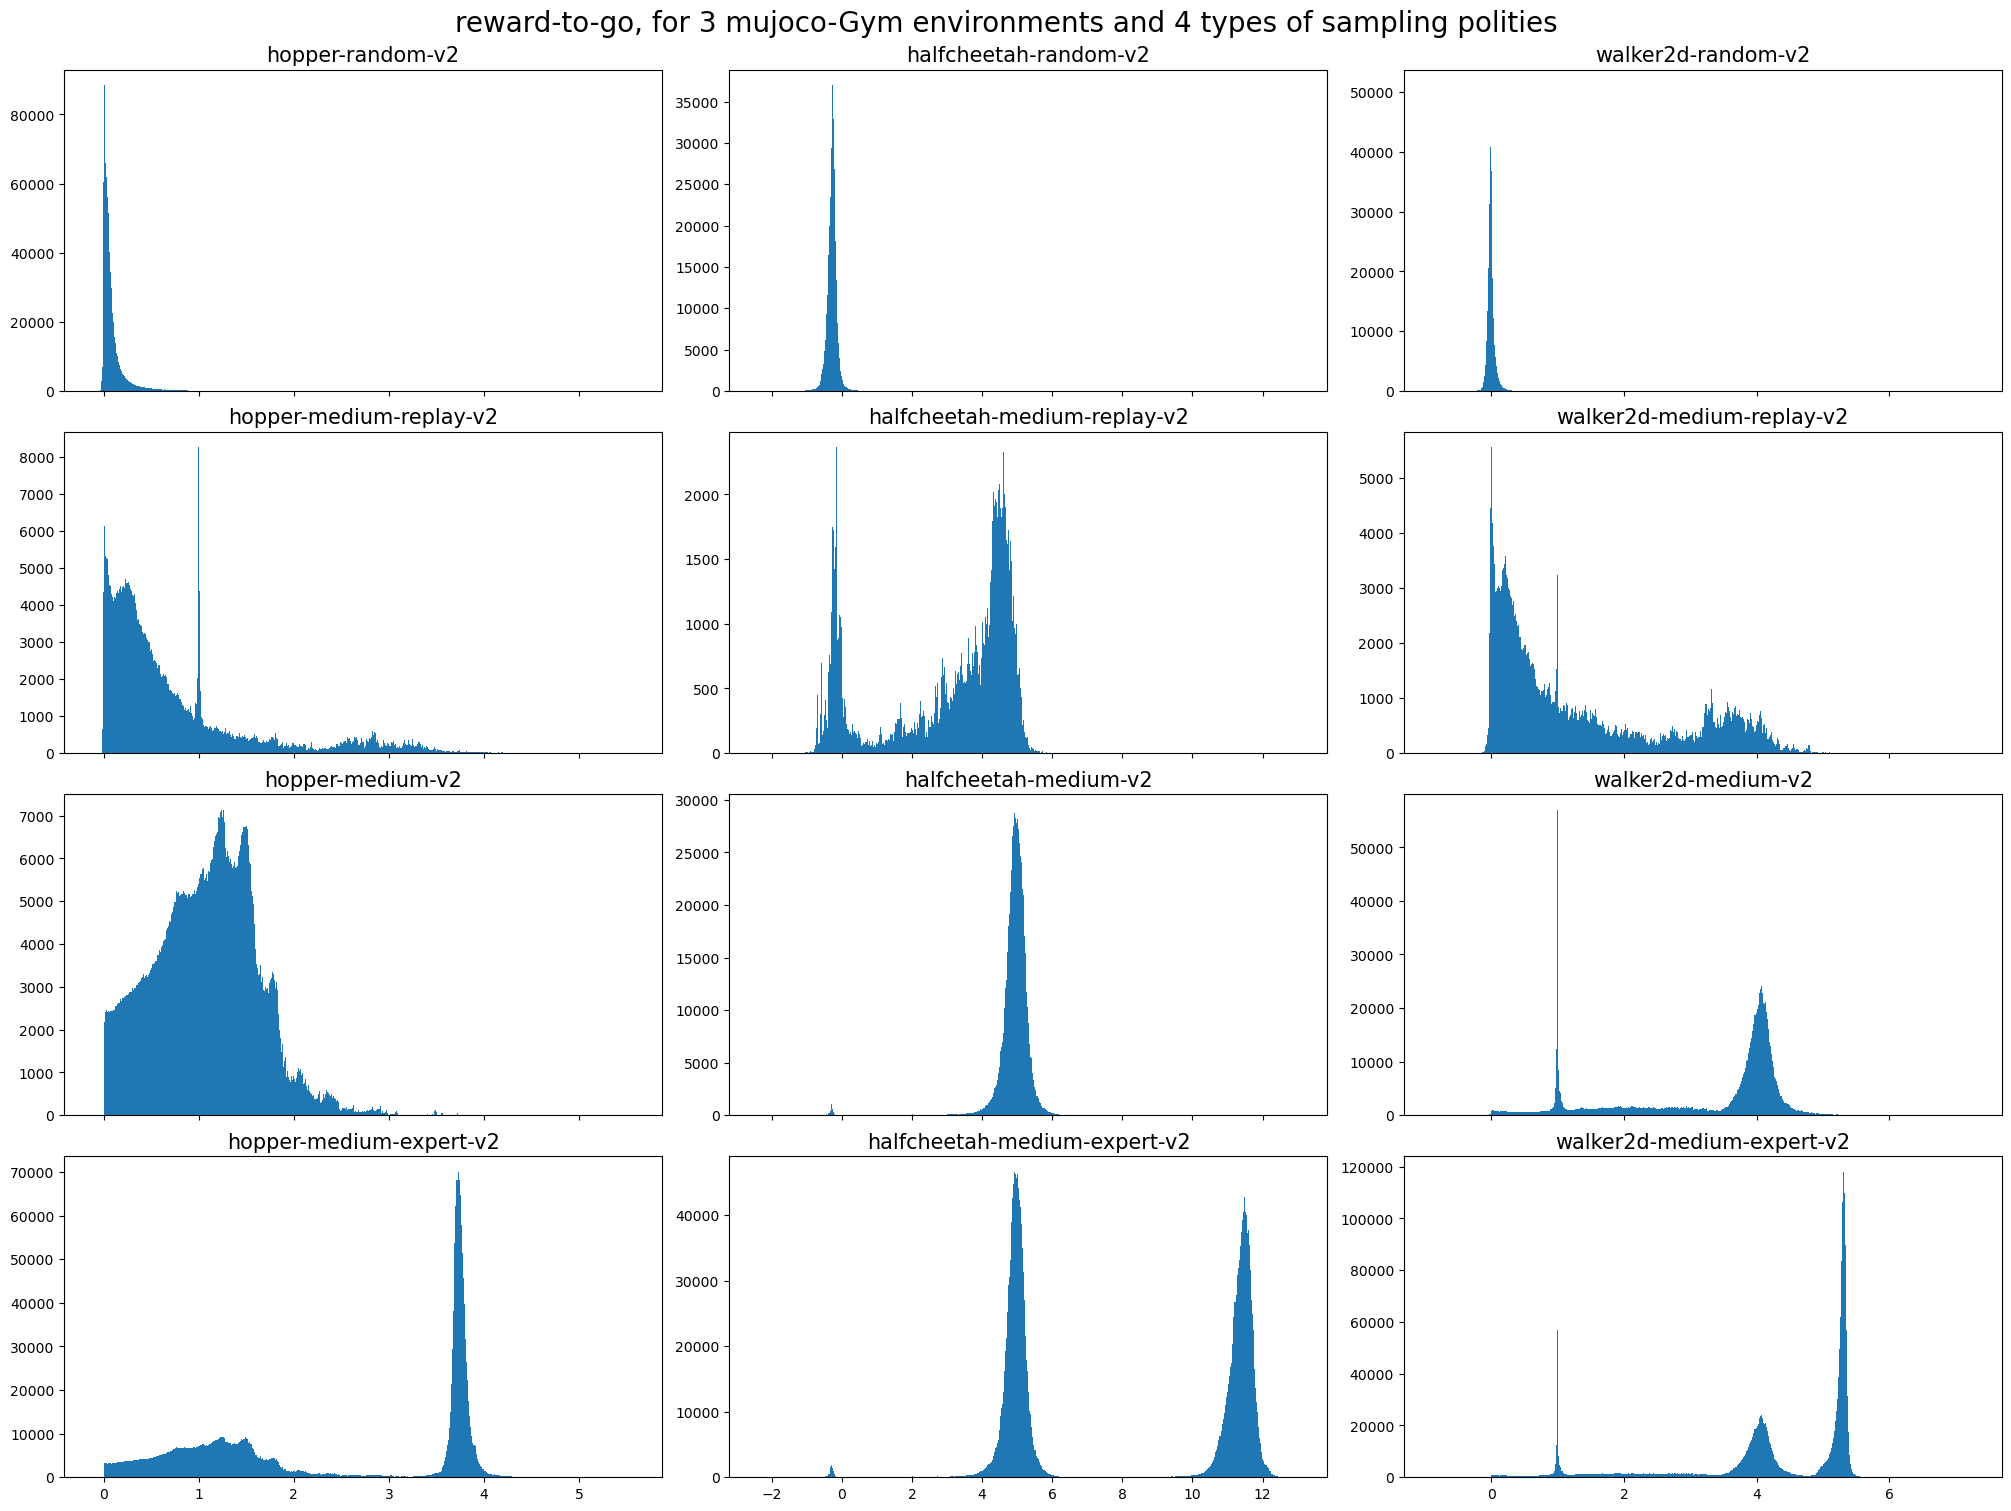

In [189]:
env_names = ['hopper', 'halfcheetah', 'walker2d']
policy_names = ['random', 'medium-replay', 'medium', 'medium-expert']

fig, axs = plt.subplots(len(policy_names), len(env_names), 
                        figsize=(20,15), sharex='col',
                        layout="constrained")

for i, policy_name in enumerate(policy_names):
    for j, env_name in enumerate(env_names):
        name = '{e}-{p}-v2'.format(e=env_name, p=policy_name)
        rtg = rtg_dict[name]
        ax = axs[i, j]
        ax.hist(rtg, bins=500)
        # sns.histplot(rtg, element="step", bins=500, ax=ax)
        ax.set_title(name, fontsize=15)

fig.suptitle("reward-to-go, for 3 mujoco-Gym environments and 4 types of sampling polities", fontsize=20)
fig.show()
# fig.savefig('reward_to_go.png')

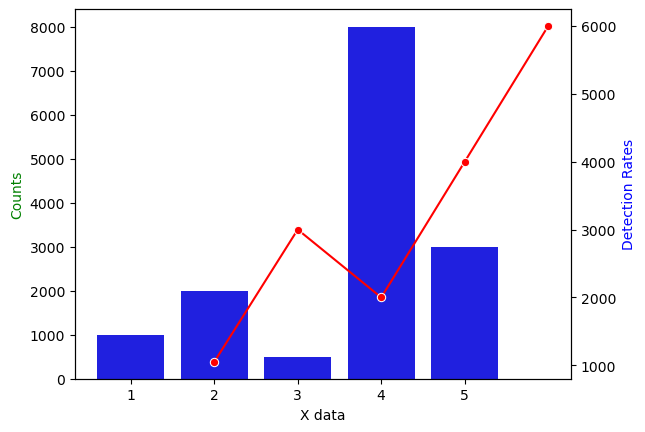

In [31]:
x = [1,2,3,4,5]
y = [1000,2000,500,8000,3000]
y1 = [1050,3000,2000,4000,6000]

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.barplot(x = x, y = y, ax = ax1, color = 'blue') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y1, marker = 'o', color = 'red', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('X data')
ax1.set_ylabel('Counts', color='g')
ax2.set_ylabel('Detection Rates', color='b')

plt.show(); # shows the plot. 

In [73]:
exp_name = exp_name_list[0]
observation_record = observation_record_dict[exp_name]
action_record = action_record_dict[exp_name]
reward_record = reward_record_dict[exp_name]
termination_record = termination_record_dict[exp_name]

print(action_record.shape)
print(rtg_list.shape)
print(termination_record.shape)
print(reward_record.shape)

(1999, 500, 3)
(500,)
(1999, 500)
(1999, 500)


In [84]:
np.roll(termination_record, 1, axis=1).nonzero()

(array([  59,   59,   59, ..., 1996, 1997, 1997]),
 array([456, 461, 464, ...,  57,  69, 347]))

In [96]:
def episodic_rewards(reward_record, termination_record):
    reward_sums = []
    for i in range(reward_record.shape[-1]):
        split_rewards = np.split(reward_record[:,i], np.roll(termination_record[:,i], 1).nonzero()[0])
        reward_sums += [l.sum() for l in split_rewards]
    return np.array(reward_sums)

def episodic_reward_dist(reward_record, termination_record):
    reward_sums = []
    for i in range(10):
        current_reward_record = reward_record[:,50*i:50*(i+1)]
        current_termination_record = termination_record[:,50*i:50*(i+1)]
        current_reward_sums = episodic_rewards(current_reward_record, current_termination_record)
        reward_sums.append(np.array(current_reward_sums))
    return reward_sums

In [ ]:
results = {}
for exp_name in exp_name_list:
    observation_record = observation_record_dict[exp_name]
    action_record = action_record_dict[exp_name]
    reward_record = reward_record_dict[exp_name]
    termination_record = termination_record_dict[exp_name]

    rtg_list = rtg_list_dict[exp_name]
    xs = [rtg_list[50 * i] for i in range(10)]
    rs = episodic_reward_dist(reward_record, termination_record)
    ys = [i.mean() for i in rs]
    plt.plot(xs, ys)
    plt.show()
    results[exp_name] = max(ys)

In [114]:
results

{'hopper-random': 1003.4926486570134,
 'hopper-medium-replay': 115.13590528560597,
 'hopper-medium': 400.063912818738,
 'hopper-medium-expert': 245.40308734065636,
 'walker2d-random': 169.565170380536,
 'walker2d-medium-replay': 621.1400742814591,
 'walker2d-medium': 1107.6248521808054,
 'walker2d-medium-expert': 663.3256441287424,
 'halfcheetah-random': -0.11073967066519634,
 'halfcheetah-medium-replay': 4309.7945981212815,
 'halfcheetah-medium': 4574.264788756791,
 'halfcheetah-medium-expert': 4996.442097921909}

In [150]:
dfs = {}

def concat(l):
    t = []
    for i in l:
        t += i
    return t

for exp_name in exp_name_list:
    df = pd.DataFrame()
    observation_record = observation_record_dict[exp_name]
    action_record = action_record_dict[exp_name]
    reward_record = reward_record_dict[exp_name]
    termination_record = termination_record_dict[exp_name]

    rtg_list = rtg_list_dict[exp_name]
    xs = [rtg_list[50 * i] for i in range(10)]
    rs = episodic_reward_dist(reward_record, termination_record)
    ys = [i.mean() for i in rs]
    
    temp = []
    for i, rtg in enumerate(xs):
        temp.append([rtg] * len(rs[i]))
    df['target rtg'] = concat(temp)
    df['episodic reward'] = concat([i.tolist() for i in rs])
    
    dfs[exp_name] = df

In [222]:
df = dfs[exp_name_list[0]]



/tmp/ipykernel_22629/2437818813.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


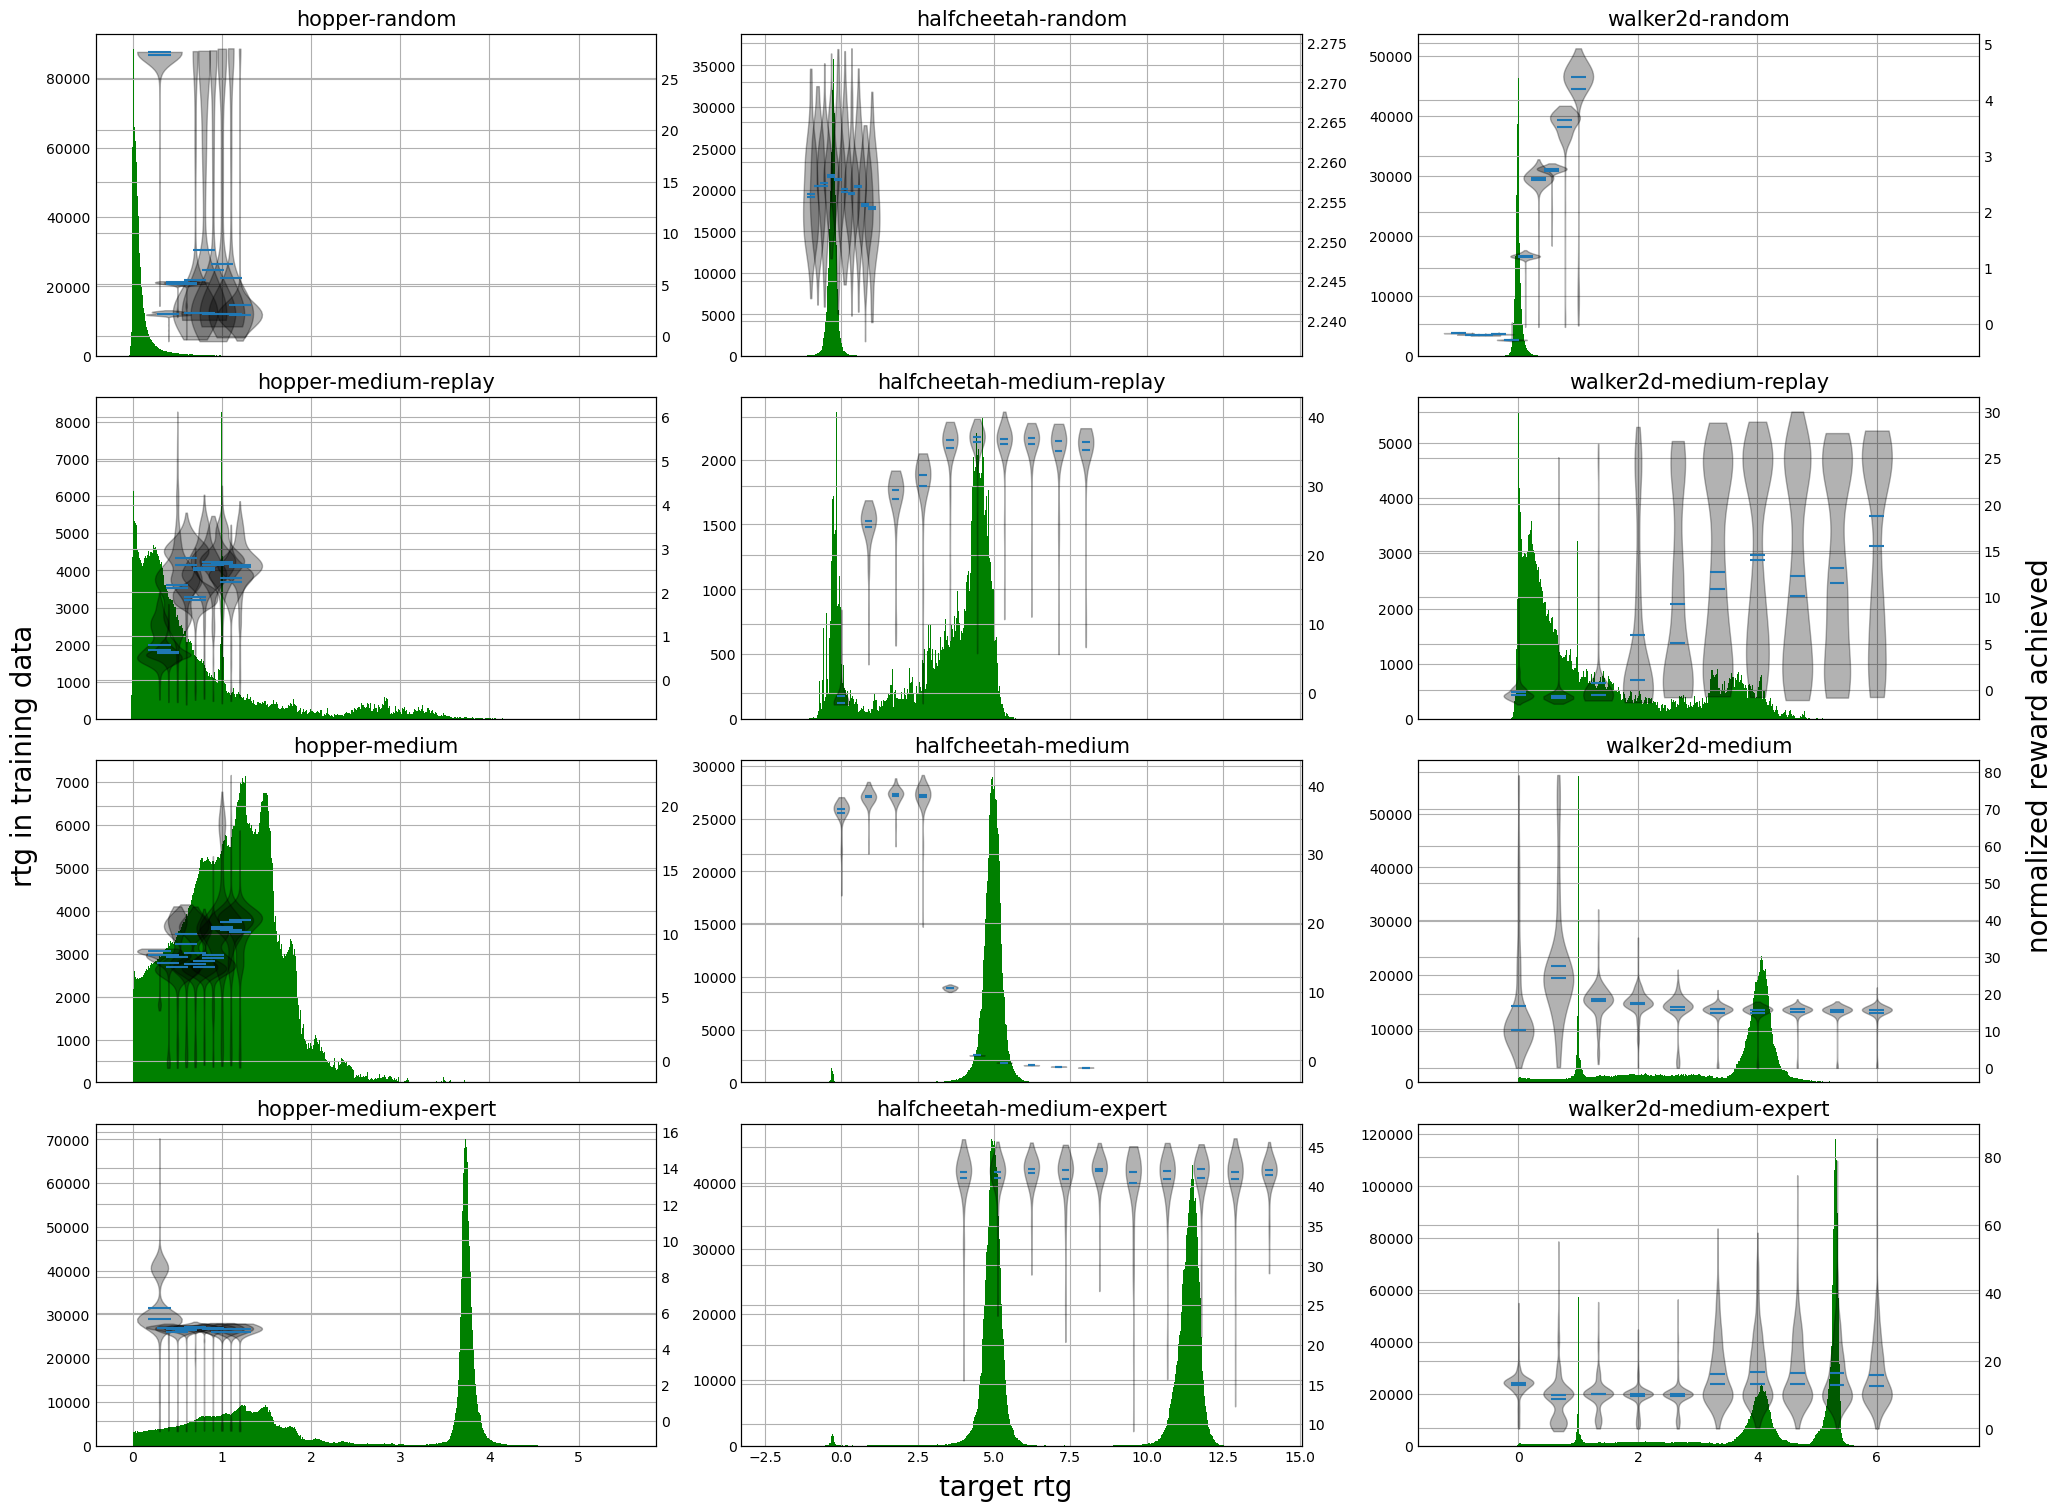

In [258]:
env_names = ['hopper', 'halfcheetah', 'walker2d']
policy_names = ['random', 'medium-replay', 'medium', 'medium-expert']

def normal_score(x, random_performance, expert_performance):
    return 100 * (x - random_performance)/(expert_performance - random_performance)

random_performances = {
    "hopper": 20,
    "halfcheetah": -285,
    "walker2d": 2
    }
expert_performances = {
    "hopper": 3624,
    "halfcheetah": 12330,
    "walker2d": 4005
    }

fig, axs = plt.subplots(len(policy_names), len(env_names), 
                        figsize=(20,15), sharex='col',
                        layout="constrained")

for j, env_name in enumerate(env_names):
    for i, policy_name in enumerate(policy_names):
        exp_name = '{e}-{p}'.format(e=env_name, p=policy_name)
        
        ax = axs[i, j]
        ax2 = ax.twinx()
        rtg = rtg_offline_dict[f'{exp_name}-v2']
        ax.hist(rtg, bins=500, color='green')
        
        df = dfs[exp_name]
        unique_rtgs = np.unique(df["target rtg"].to_numpy())
        
        scores = [df[df['target rtg'] == r]['episodic reward'] for r in unique_rtgs]
        normalized_scores = [normal_score(score, random_performances[env_name], expert_performances[env_name]).tolist() for score in scores]
        vp = ax2.violinplot(normalized_scores, positions=unique_rtgs,
                       showmeans=True, showextrema=False, showmedians=True,)
        for pc in vp['bodies']:
            pc.set_facecolor('black')
            pc.set_edgecolor('black')
        ax.set_title(exp_name, fontsize=15)
        # ax.set_ylabel('rtg in training data')
        # ax2.set_ylabel('normalized reward achieved')

fig.text(1.01,0.5, 'normalized reward achieved', va='center', rotation='vertical', fontsize=20)

fig.supxlabel('target rtg', fontsize=20)
fig.supylabel('rtg in training data', fontsize=20)
# fig.suptitle("reward-to-go, for 3 mujoco-Gym environments and 4 types of sampling polities", fontsize=20)
fig.show()

In [259]:
fig.savefig('final_performance.png')